In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import csv
import seaborn as sns

In [3]:
MODEL_PATH = "/content/drive/MyDrive/vgg16_finetuned.h5"   # change if needed
TEST_DIR = "/content/drive/MyDrive/Dataset/test"   # change if needed
IMG_SIZE = (224, 224)
BATCH_SIZE = 1   # using batch_size=1 keeps mapping simple (generator was used earlier with batch_size=1)

In [4]:
# Load model
model = load_model(MODEL_PATH)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,862,531 (56.70 MB)

 Trainable params: 9,587,073 (36.57 MB)

 Non-trainable params: 5,275,456 (20.12 MB)

 Optimizer params: 2 (12.00 B)

In [5]:
# Prepare test generator (must match preprocessing used at training)
test_gen = ImageDataGenerator(rescale=1./255)
test_data = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 1656 images belonging to 2 classes.


In [6]:
def evaluate_on_generator(gen, model):
    y_true = []
    y_pred = []
    y_prob = []
    steps = len(gen)
    for i in range(steps):
        x_batch, y_batch = gen[i]      # batch_size=1 -> x_batch.shape = (1, H, W, C)
        preds = model.predict(x_batch, verbose=0)
        y_prob.append(preds.ravel()[0])
        y_pred.append(int(preds.ravel()[0] > 0.5))
        y_true.append(int(y_batch.ravel()[0]))
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)
    acc = accuracy_score(y_true, y_pred)
    return acc, y_true, y_pred, y_prob

In [7]:
# Evaluate clean accuracy
clean_acc, y_true_clean, y_pred_clean, y_prob_clean = evaluate_on_generator(test_data, model)
print(f"Clean test accuracy: {clean_acc*100:.2f}%")

Clean test accuracy: 79.17%


In [8]:
# FGSM attack function
loss_object = tf.keras.losses.BinaryCrossentropy()

In [9]:
@tf.function
def create_adversarial_pattern(model, input_image, input_label):
    # input_image: shape (1, H, W, C), values in [0,1]
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image, training=False)
        loss = loss_object(tf.cast(input_label, tf.float32), prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

In [10]:
def fgsm_perturbation(x, y, eps):
    x_tf = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tf = tf.convert_to_tensor([[y]], dtype=tf.float32)

    signed_grad = create_adversarial_pattern(model, x_tf, y_tf)
    adv_x = x_tf + eps * signed_grad
    adv_x = tf.clip_by_value(adv_x, 0.0, 1.0)

    return adv_x.numpy(), signed_grad.numpy()


In [22]:
# Evaluate for multiple epsilons
epsilons = [0.001, 0.002, 0.005, 0.01, 0.02]   # try small to moderate perturbations
results = []

# Optional: folder to save samples
SAVE_ADV_SAMPLES = True
ADV_SAVE_DIR = "/content/drive/MyDrive/adv_samples"
os.makedirs(ADV_SAVE_DIR, exist_ok=True)

In [ ]:
for eps in epsilons:
    print(f"\nRunning FGSM with epsilon = {eps}")
    y_true = []
    y_pred_adv = []
    y_prob_adv = []
    steps = len(test_data)
    # iterate through test generator
    for i in range(steps):
        x_batch, y_batch = test_data[i]   # (1,H,W,C), values already rescaled to [0,1]
        y = int(y_batch.ravel()[0])
        adv_x, _ = fgsm_perturbation(x_batch, y, eps)   # returns np array (1,H,W,C)
        preds = model.predict(adv_x, verbose=0)
        y_prob_adv.append(preds.ravel()[0])
        y_pred_adv.append(int(preds.ravel()[0] > 0.5))
        y_true.append(y)

        # Save a few adversarial samples for inspection (first 5)
        if SAVE_ADV_SAMPLES and i < 5:
            adv_img = (adv_x[0] * 255.0).astype(np.uint8)
            pil = Image.fromarray(adv_img)
            filename = os.path.join(ADV_SAVE_DIR, f"eps_{eps}_idx_{i}_label_{y}_pred_{int(preds.ravel()[0]>0.5)}.png")
            pil.save(filename)

    y_true = np.array(y_true)
    y_pred_adv = np.array(y_pred_adv)
    y_prob_adv = np.array(y_prob_adv)
    acc_adv = accuracy_score(y_true, y_pred_adv)
    drop = clean_acc - acc_adv
    print(f"Epsilon {eps}: adv accuracy = {acc_adv*100:.2f}%, drop = {drop*100:.2f}%")
    results.append((eps, acc_adv, drop))


Running FGSM with epsilon = 0.001
Epsilon 0.001: adv accuracy = 40.34%, drop = 38.83%

Running FGSM with epsilon = 0.002
Epsilon 0.002: adv accuracy = 19.38%, drop = 59.78%

Running FGSM with epsilon = 0.005
Epsilon 0.005: adv accuracy = 3.32%, drop = 75.85%

Running FGSM with epsilon = 0.01
Epsilon 0.01: adv accuracy = 0.42%, drop = 78.74%

Running FGSM with epsilon = 0.02
Epsilon 0.02: adv accuracy = 0.30%, drop = 78.86%


In [ ]:
# Summarize
print("\nSummary \nepsilon, adv_acc, accuracy_drop")
for eps, acc_adv, drop in results:
    print(f"{eps:6}  {acc_adv*100:6.2f}%   {drop*100:6.2f}%")


Summary 
epsilon, adv_acc, accuracy_drop
 0.001   40.34%    38.83%
 0.002   19.38%    59.78%
 0.005    3.32%    75.85%
  0.01    0.42%    78.74%
  0.02    0.30%    78.86%


In [ ]:
# =====================================================
# REBUILD y_true_dict AND y_pred_dict FOR CONF MATRICES
# =====================================================

# epsilons = [0.0, 0.001, 0.002, 0.005, 0.01, 0.02]

y_true_dict = {}
y_pred_dict = {}

print("\nRecomputing predictions for confusion matrices...\n")

# ---- CLEAN PREDICTIONS (eps = 0) ----
y_true_clean = test_data.classes
y_prob_clean = model.predict(test_data, verbose=0).ravel()
y_pred_clean = (y_prob_clean > 0.5).astype(int)

y_true_dict[0.0] = y_true_clean
y_pred_dict[0.0] = y_pred_clean

print("Saved clean predictions.")


# ---- FGSM PREDICTIONS FOR EACH EPSILON ----
for eps in epsilons:
    if eps == 0.0:
        continue

    print(f"Processing epsilon = {eps}")
    y_true = []
    y_pred = []

    for i in range(len(test_data)):

        x_batch, y_batch = test_data[i]
        y = int(y_batch.ravel()[0])

        adv_x, _ = fgsm_perturbation(x_batch, y, eps)
        pred = model.predict(adv_x, verbose=0).ravel()[0]

        y_true.append(y)
        y_pred.append(int(pred > 0.5))

    y_true_dict[eps] = np.array(y_true)
    y_pred_dict[eps] = np.array(y_pred)

print("\nDONE! y_true_dict and y_pred_dict are now available.")



Recomputing predictions for confusion matrices...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Saved clean predictions.
Processing epsilon = 0.001
Processing epsilon = 0.002
Processing epsilon = 0.005
Processing epsilon = 0.01
Processing epsilon = 0.02

DONE! y_true_dict and y_pred_dict are now available.


In [16]:
# Ensure consistent style for research paper figures
plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.2)
dpi = 300


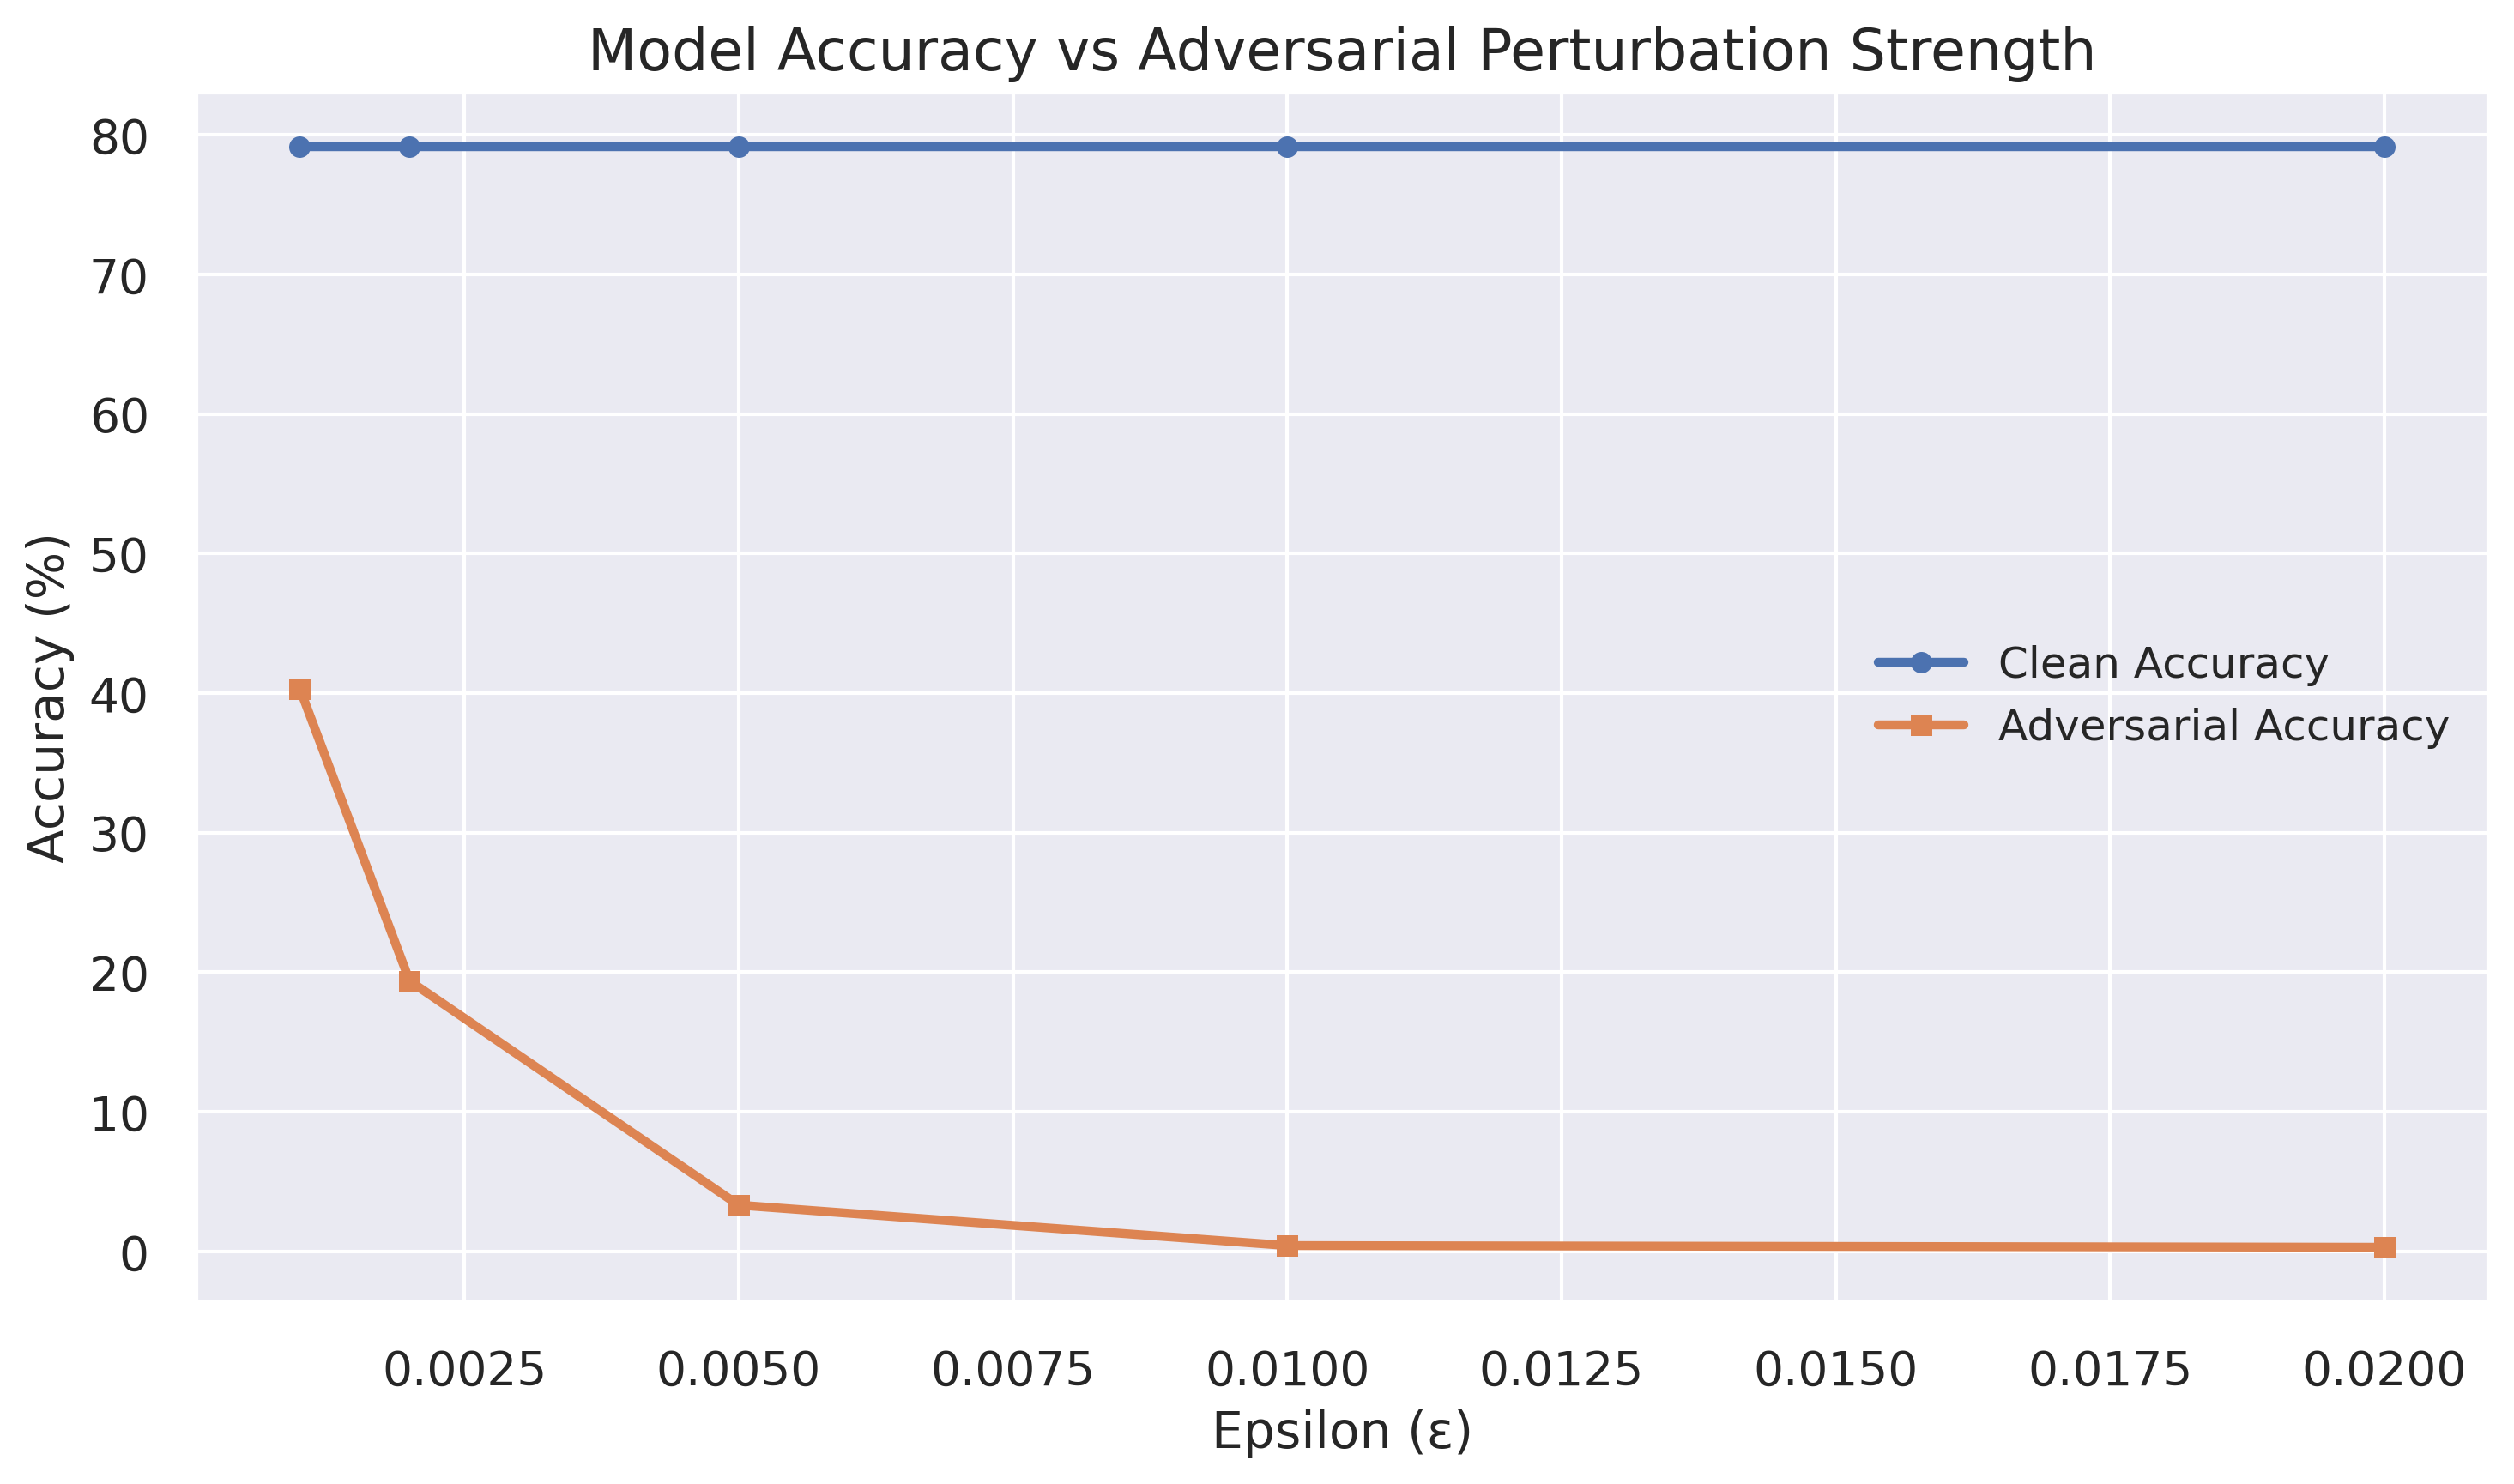

In [ ]:
# 1) ACCURACY vs EPSILON
# ===============================================
eps_vals = [x[0] for x in results]
adv_acc_vals = [x[1]*100 for x in results]
clean_vals = [clean_acc*100 for _ in eps_vals]

plt.figure(figsize=(10,6), dpi=dpi)
plt.plot(eps_vals, clean_vals, 'o-', label="Clean Accuracy", linewidth=2.5)
plt.plot(eps_vals, adv_acc_vals, 's-', label="Adversarial Accuracy", linewidth=2.5)
plt.xlabel("Epsilon (ε)", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.title("Model Accuracy vs Adversarial Perturbation Strength", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("accuracy_vs_epsilon.png", dpi=dpi)
plt.show()

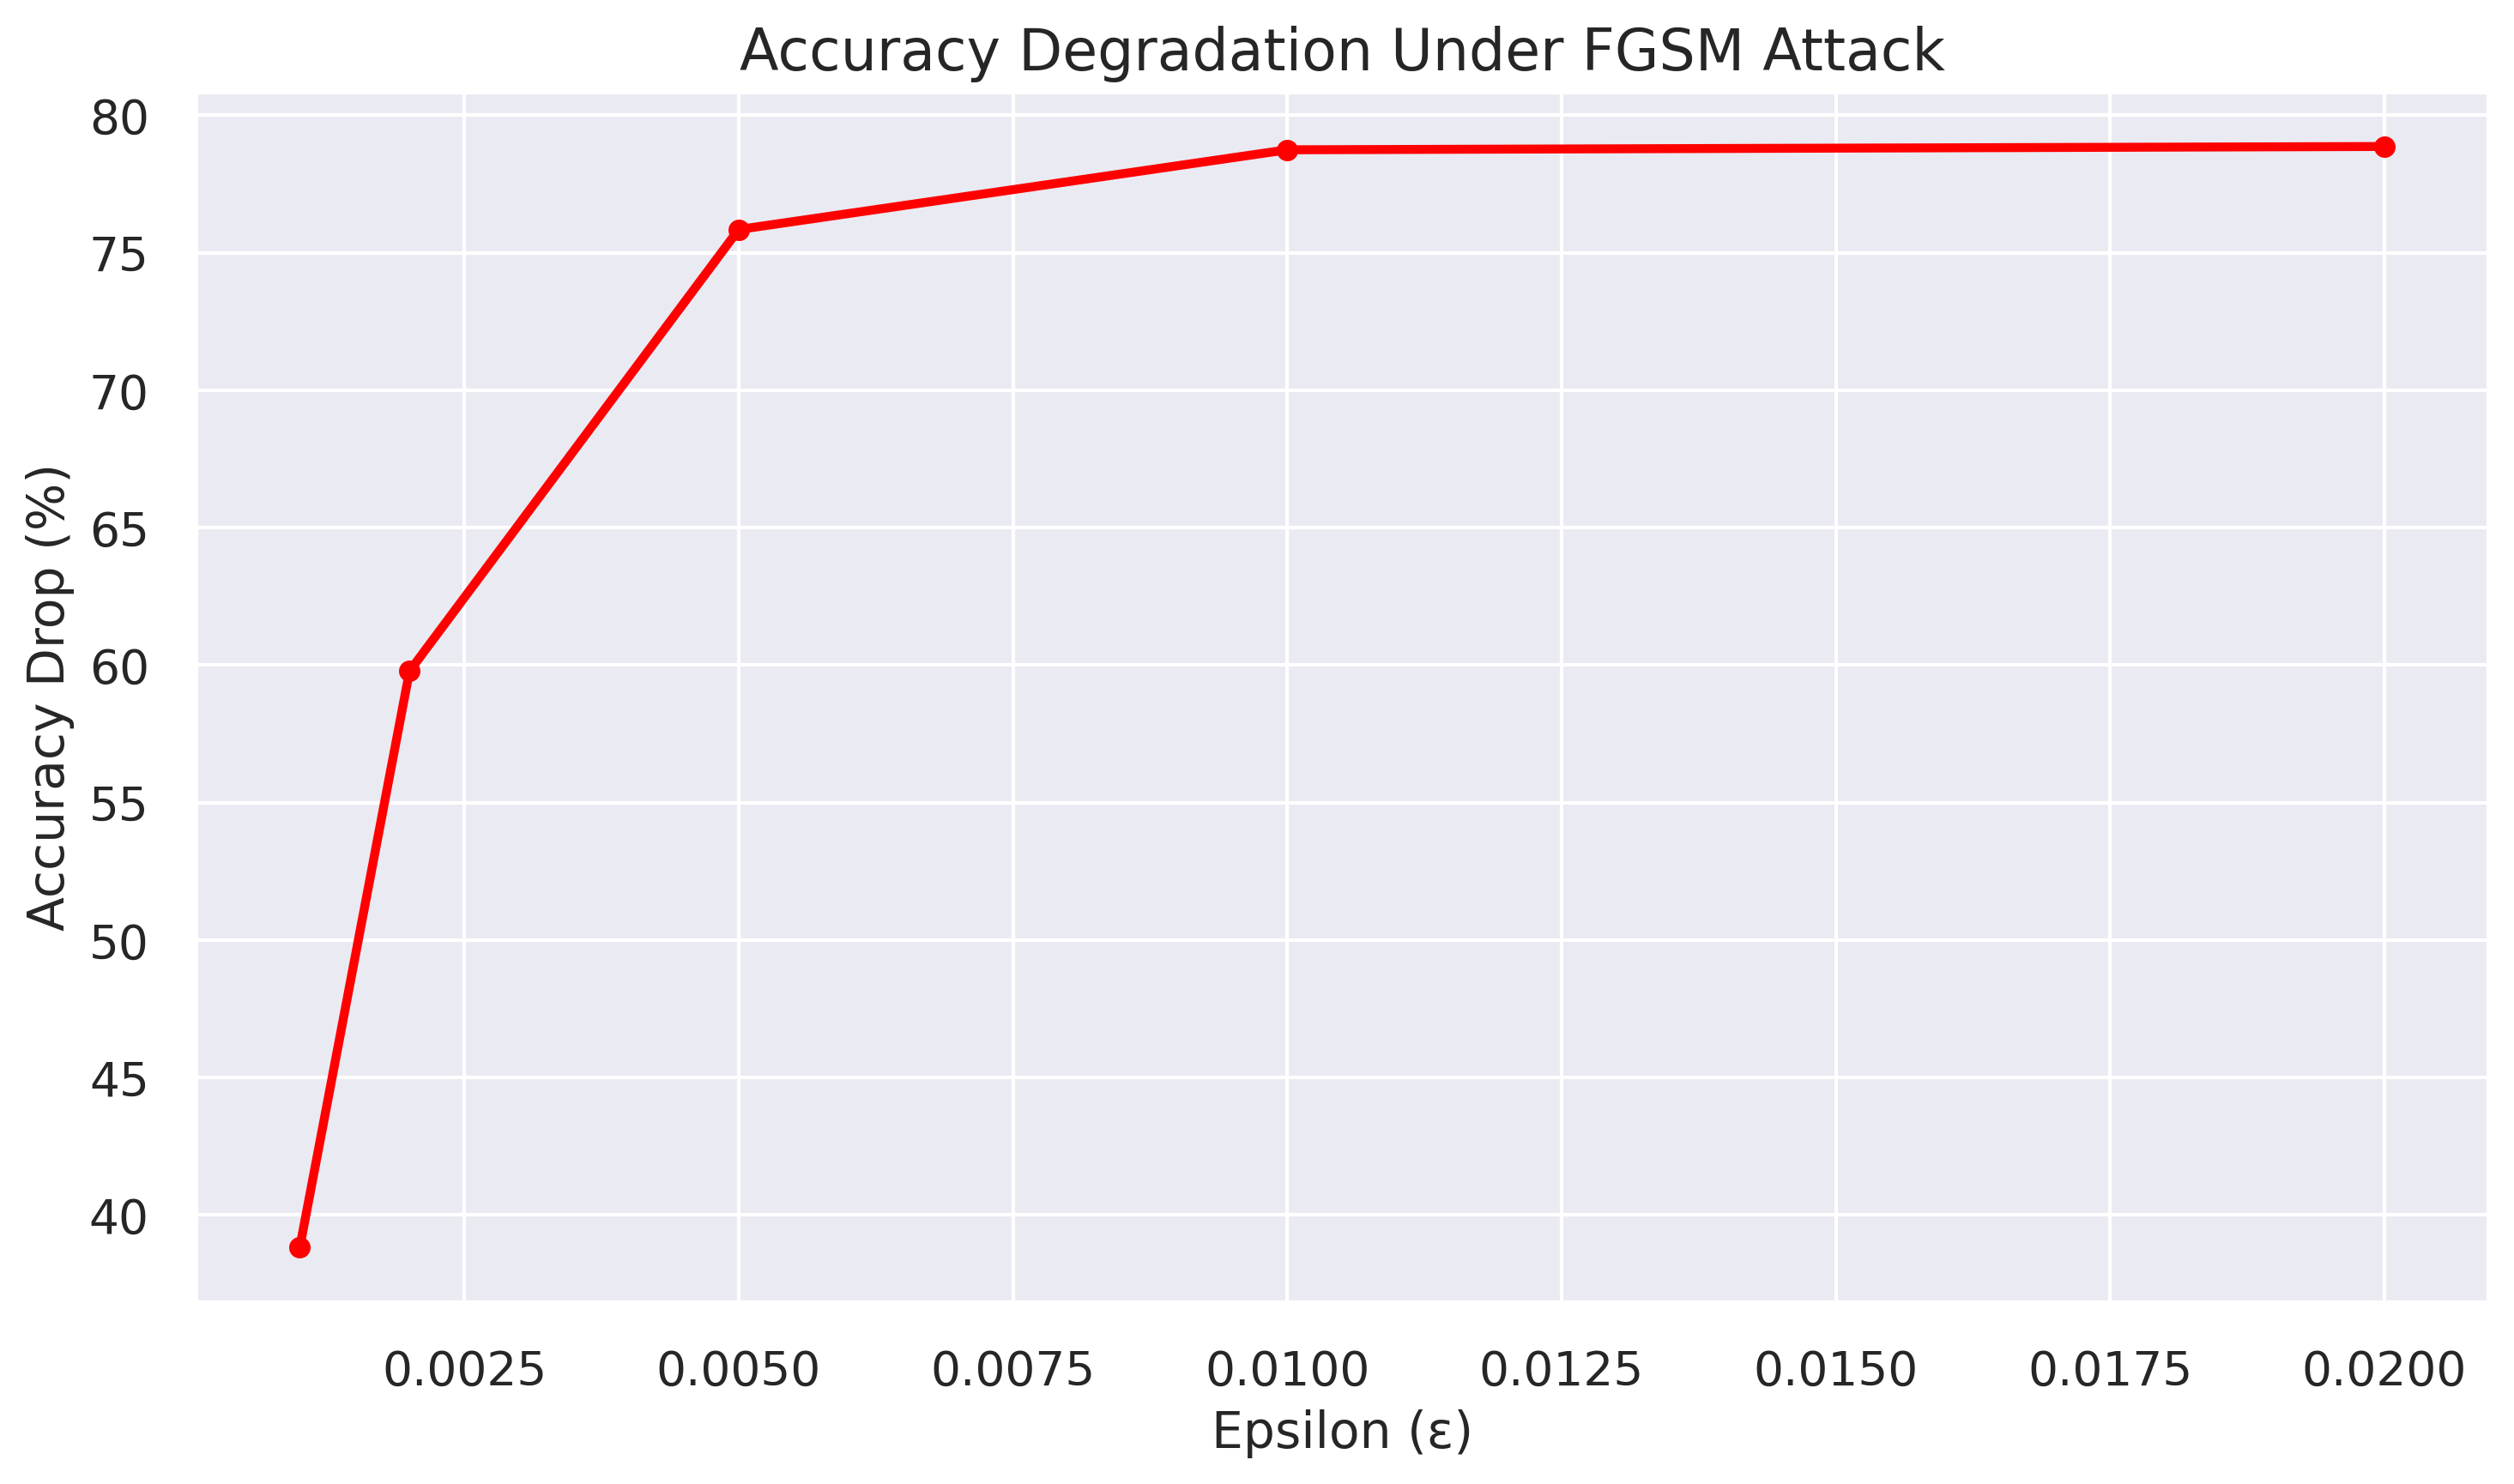

In [ ]:
# 2) ACCURACY DROP vs EPSILON
# ===============================================
drops = [(clean_acc - x[1]) * 100 for x in results]

plt.figure(figsize=(10,6), dpi=dpi)
plt.plot(eps_vals, drops, 'o-', color='red', linewidth=2.5)
plt.xlabel("Epsilon (ε)", fontsize=14)
plt.ylabel("Accuracy Drop (%)", fontsize=14)
plt.title("Accuracy Degradation Under FGSM Attack", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig("accuracy_drop_vs_epsilon.png", dpi=dpi)
plt.show()

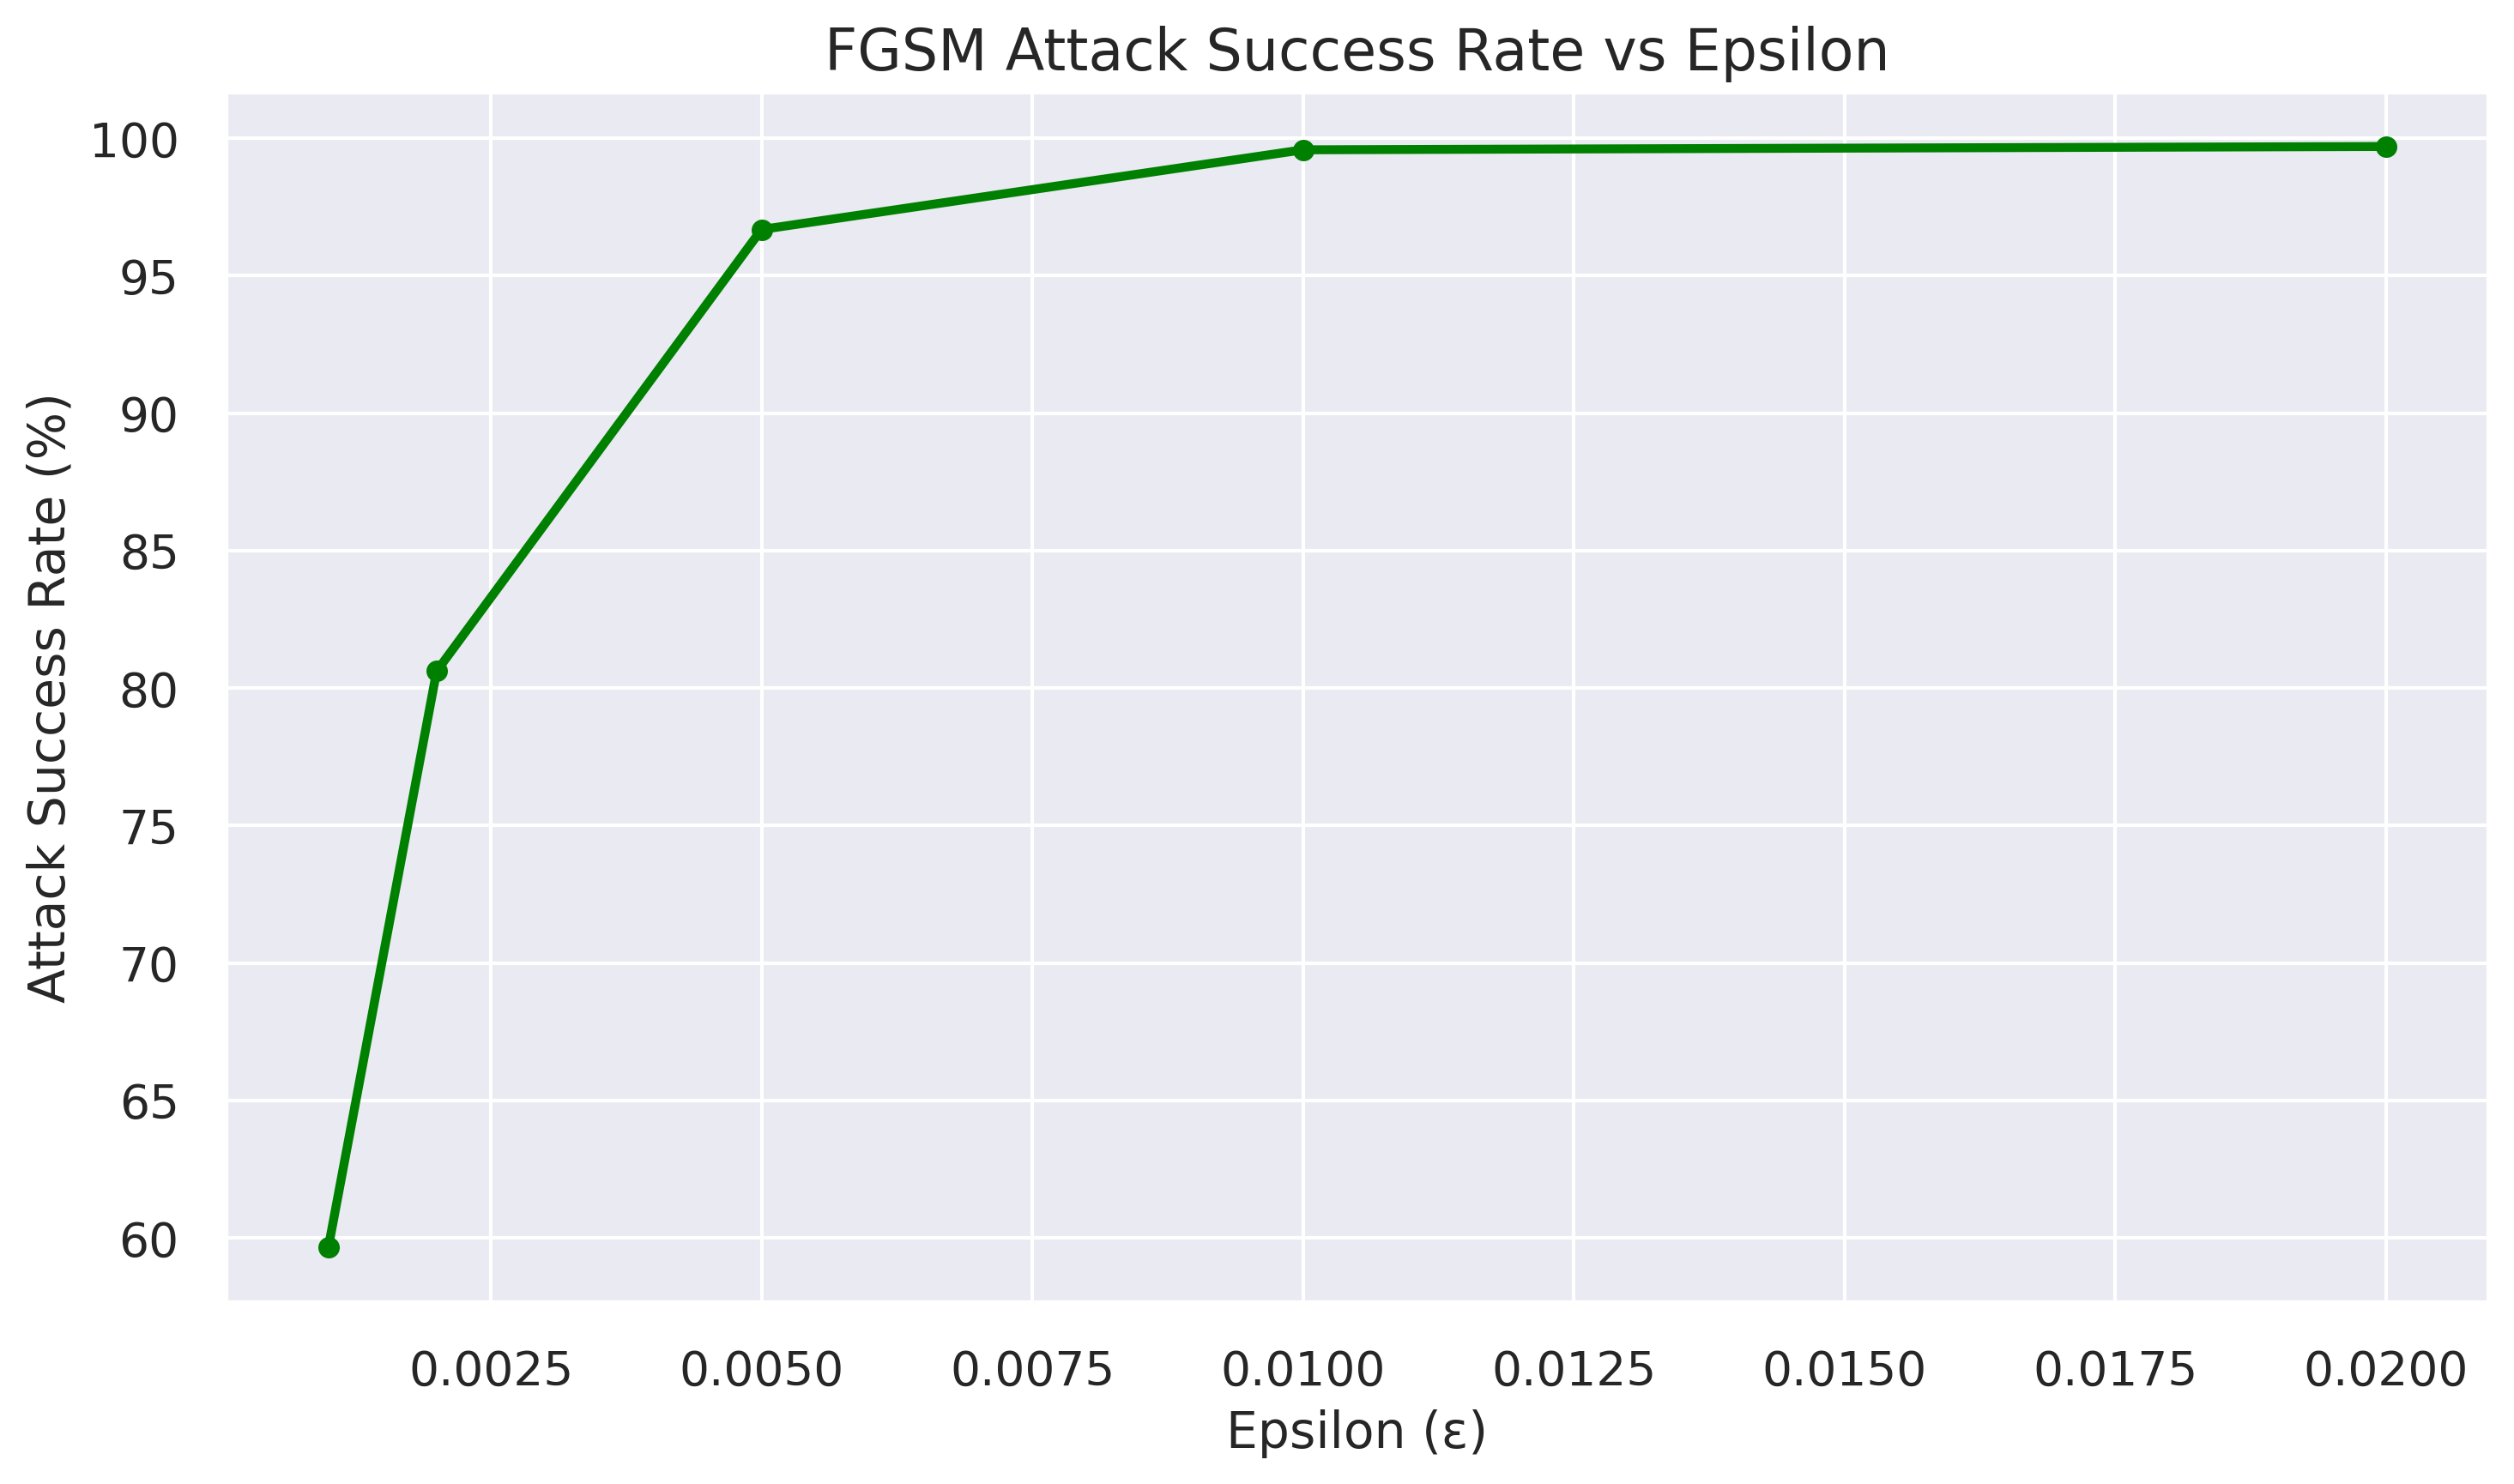

In [ ]:
# 3) ATTACK SUCCESS RATE (ASR)
# ===============================================
asr_vals = [(1 - x[1]) * 100 for x in results]

plt.figure(figsize=(10,6), dpi=dpi)
plt.plot(eps_vals, asr_vals, 'o-', color='green', linewidth=2.5)
plt.xlabel("Epsilon (ε)", fontsize=14)
plt.ylabel("Attack Success Rate (%)", fontsize=14)
plt.title("FGSM Attack Success Rate vs Epsilon", fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.savefig("asr_vs_epsilon.png", dpi=dpi)
plt.show()


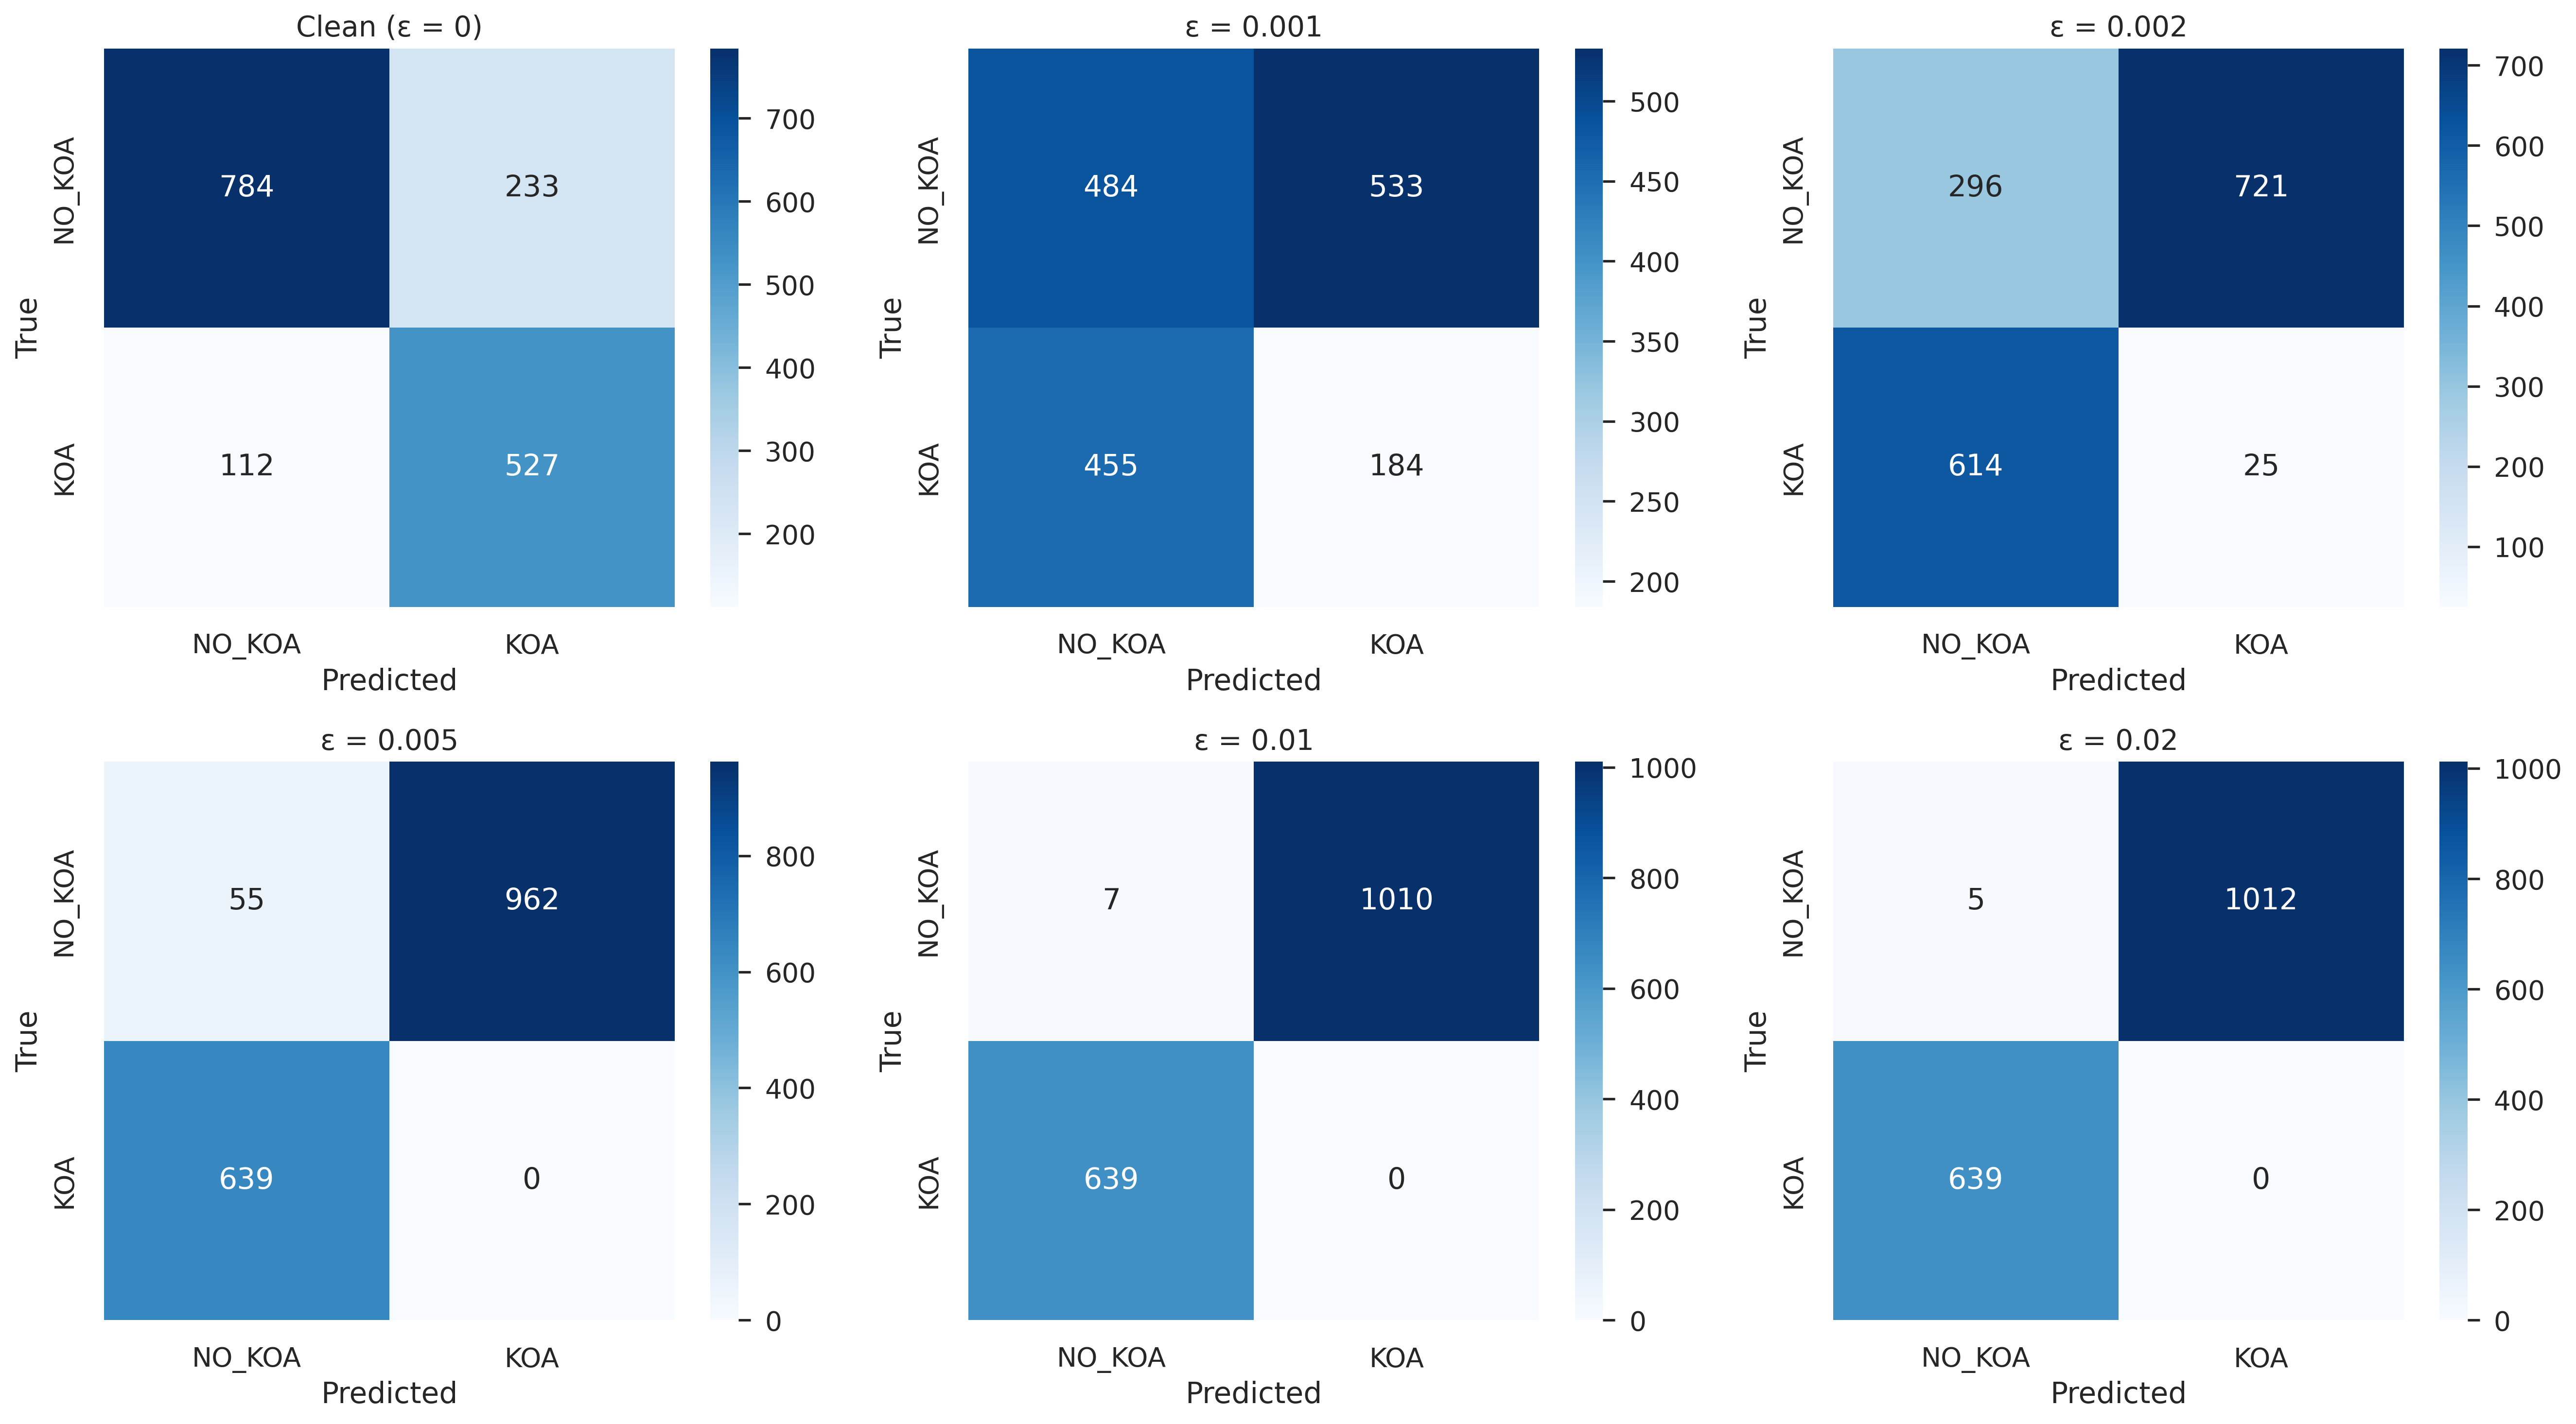

In [ ]:
# 4) CONFUSION MATRICES FOR SELECT EPSILONS
# ===============================================
selected_eps = [0.0, 0.001, 0.002, 0.005, 0.01, 0.02]

plt.figure(figsize=(18,10), dpi=dpi)

for idx, eps in enumerate(selected_eps):
    if eps == 0.0:
        y_true = y_true_clean
        y_pred = y_pred_clean
        title = "Clean (ε = 0)"
    else:
        y_true = y_true_dict[eps]
        y_pred = y_pred_dict[eps]
        title = f"ε = {eps}"

    cm = confusion_matrix(y_true, y_pred)

    plt.subplot(2, 3, idx+1)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["NO_KOA", "KOA"],
        yticklabels=["NO_KOA", "KOA"]
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Predicted")
    plt.ylabel("True")

plt.tight_layout()
plt.savefig("confusion_matrices_eps_0_to_002.png", dpi=dpi)
plt.show()

/tmp/ipython-input-2709935682.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  adv_x, grad = fgsm_perturbation(x, int(y), chosen_eps)


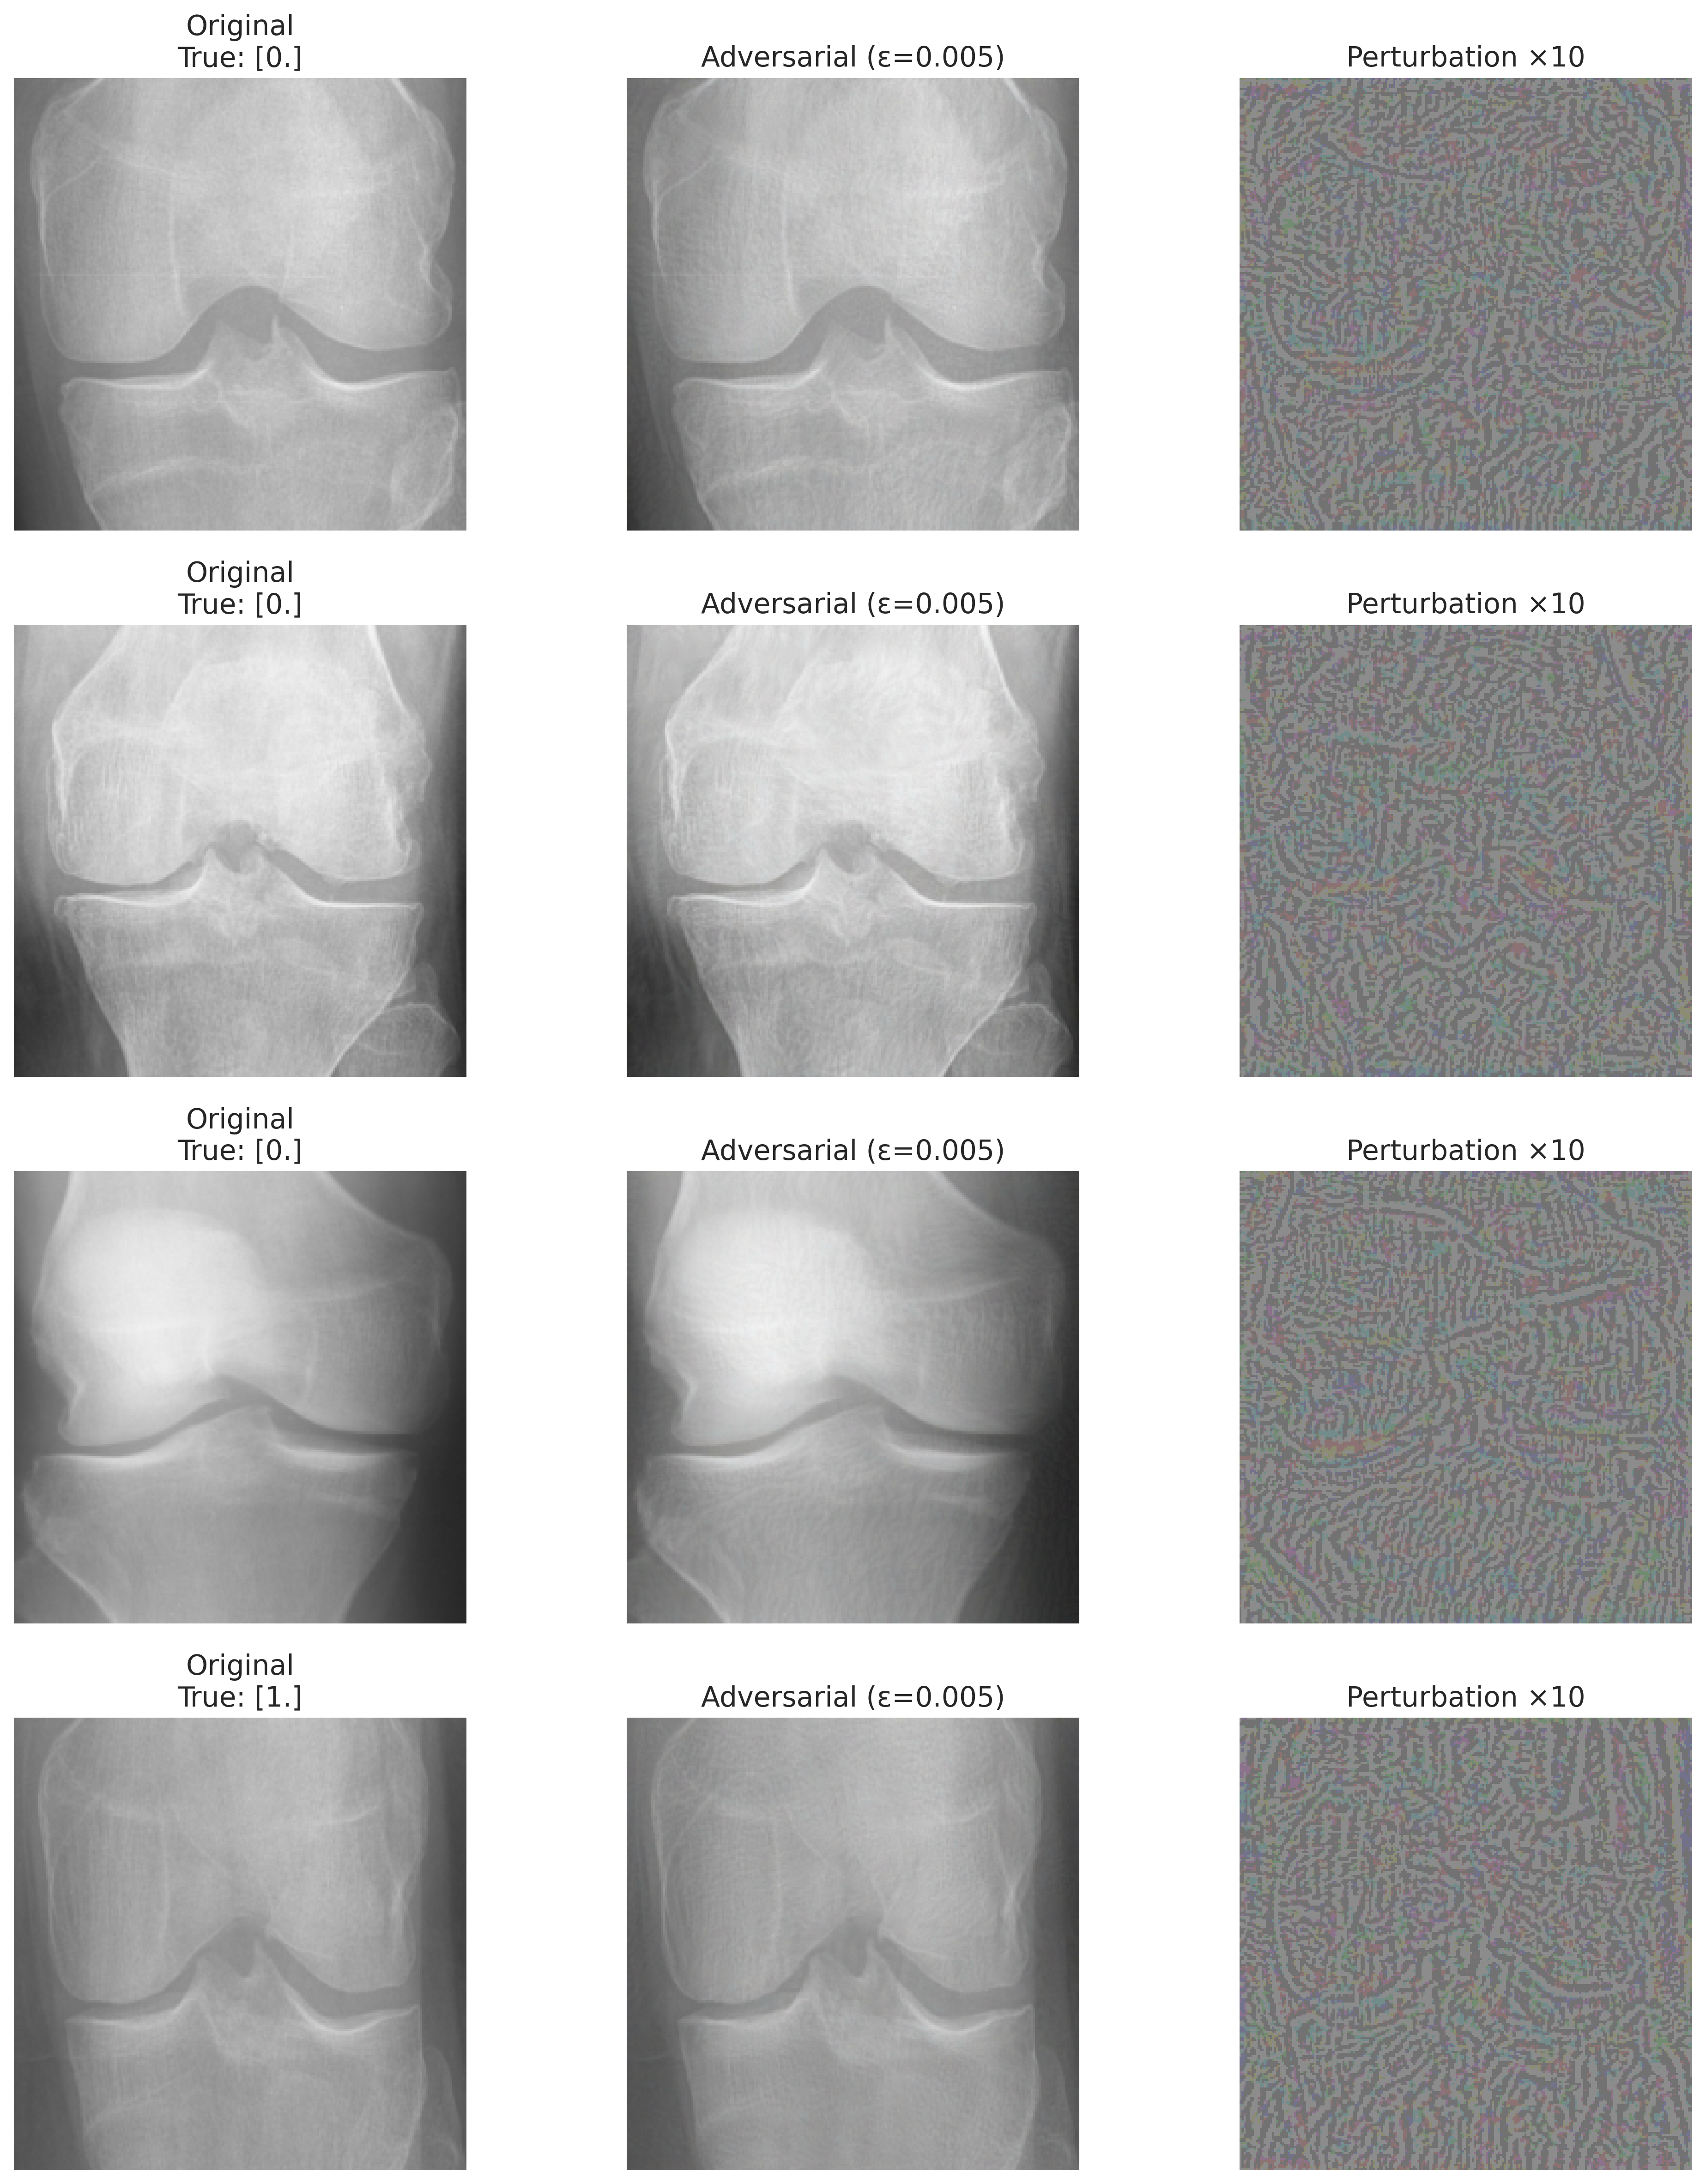

In [18]:
# 5) ADVERSARIAL EXAMPLE VISUALIZATION PANEL
# ===============================================
num_examples = 4
indices = np.random.choice(len(test_data), num_examples, replace=False)
chosen_eps = 0.005  # you are using epsilon=0.005 for saving dataset

plt.figure(figsize=(14, num_examples * 4), dpi=dpi)

for i, idx in enumerate(indices):
    x, y = test_data[idx]
    adv_x, grad = fgsm_perturbation(x, int(y), chosen_eps)
    diff = adv_x - x

    # Original
    plt.subplot(num_examples, 3, i*3+1)
    plt.imshow(x[0], cmap='gray')
    plt.title(f"Original\nTrue: {y}")
    plt.axis('off')

    # Adversarial
    plt.subplot(num_examples, 3, i*3+2)
    plt.imshow(adv_x[0], cmap='gray')
    plt.title(f"Adversarial (ε={chosen_eps})")
    plt.axis('off')

    # Perturbation ×10
    plt.subplot(num_examples, 3, i*3+3)
    pert_vis = np.clip((diff[0] * 10) + 0.5, 0, 1)  # amplify
    plt.imshow(pert_vis, cmap='gray')
    plt.title("Perturbation ×10")
    plt.axis('off')

plt.tight_layout()
plt.savefig("adversarial_visualization.png", dpi=dpi)
plt.show()

In [12]:
# Optionally: classification report for a chosen epsilon (pick the largest, for example)
chosen_eps = epsilons[-3]
print(f"\nDetailed report for epsilon = {chosen_eps}")
# reload adv predictions for chosen epsilon (alternatively store them earlier)
# We'll recompute quickly for chosen_eps:
y_true = []
y_pred_adv = []
steps = len(test_data)
for i in range(steps):
    x_batch, y_batch = test_data[i]
    y = int(y_batch.ravel()[0])
    adv_x, _ = fgsm_perturbation(x_batch, y, chosen_eps)
    preds = model.predict(adv_x, verbose=0)
    y_pred_adv.append(int(preds.ravel()[0] > 0.5))
    y_true.append(y)



Detailed report for epsilon = 0.005


In [13]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred_adv, target_names=["no_koa", "koa"]))


              precision    recall  f1-score   support

      no_koa       0.08      0.05      0.06      1017
         koa       0.00      0.00      0.00       639

    accuracy                           0.03      1656
   macro avg       0.04      0.03      0.03      1656
weighted avg       0.05      0.03      0.04      1656



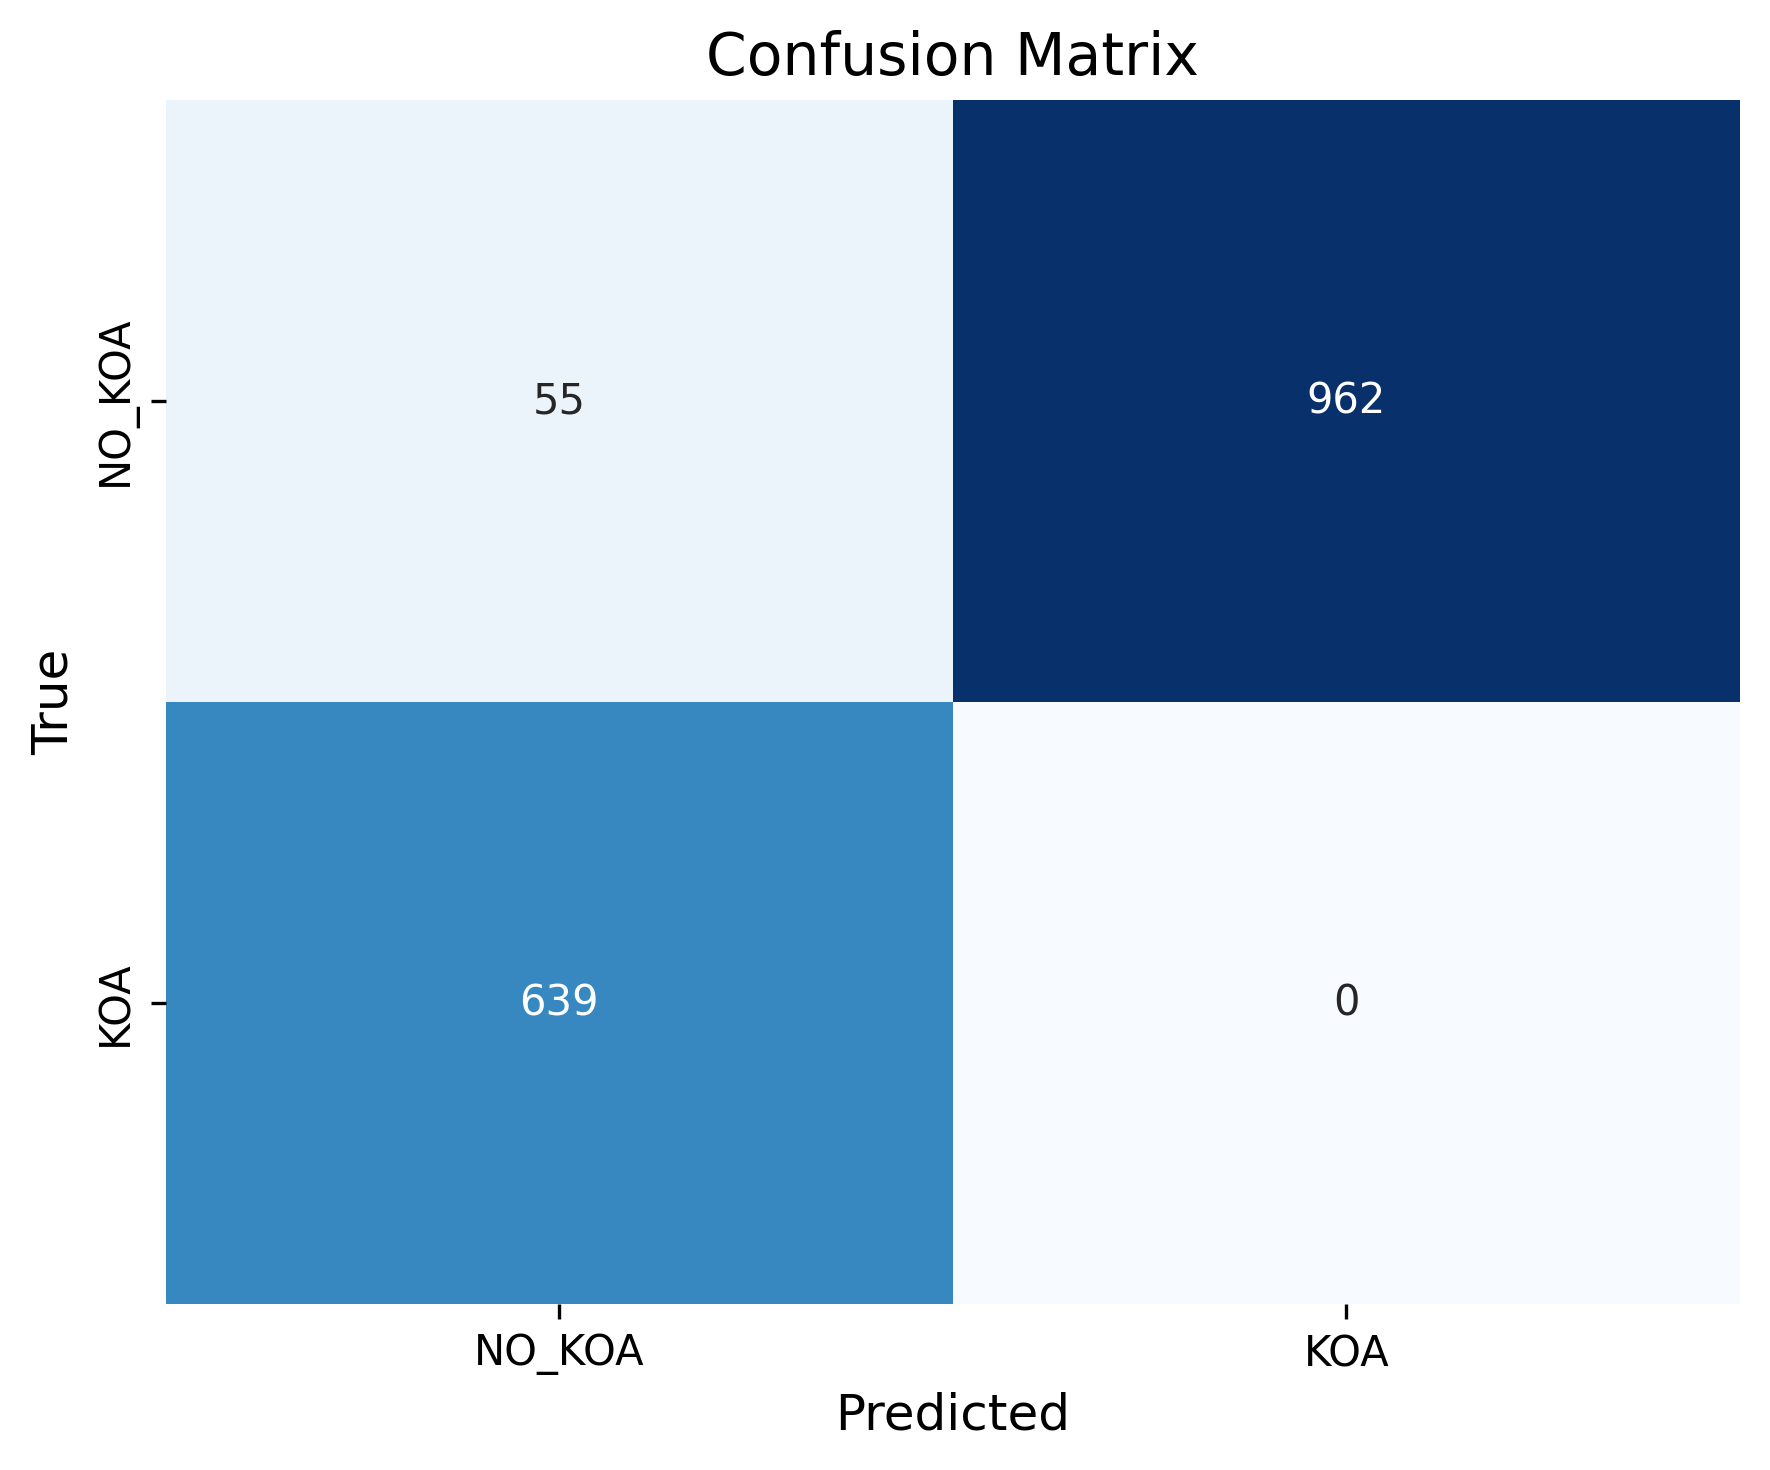

In [14]:
cm = confusion_matrix(y_true, y_pred_adv)

plt.figure(figsize=(6,5), dpi=300)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["NO_KOA", "KOA"],
    yticklabels=["NO_KOA", "KOA"],
    cbar=False
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()

In [24]:
# Choose epsilon
eps = 0.005

# Output folder
OUT_ROOT = "/content/drive/MyDrive/adv_test_epsilon_0005"
os.makedirs(OUT_ROOT, exist_ok=True)

In [25]:
print(f"\nSaving adversarial images for epsilon = {eps} ...")

# CSV to store metadata
csv_path = os.path.join(OUT_ROOT, "mapping_eps_0.005.csv")
csv_file = open(csv_path, 'w', newline='')
writer = csv.writer(csv_file)
writer.writerow(["index", "orig_rel_path", "saved_path", "true_label",
                 "pred_prob_clean", "pred_prob_adv"])


Saving adversarial images for epsilon = 0.005 ...


73

In [26]:
# Iterate through test images

# Define ADV and PERT folders
ADV_DIR = os.path.join(OUT_ROOT, "adv_images")
PERT_DIR = os.path.join(OUT_ROOT, "pert_images")

# Create the directories
os.makedirs(ADV_DIR, exist_ok=True)
os.makedirs(PERT_DIR, exist_ok=True)

steps = len(test_data)

for i in range(steps):
    x_batch, y_batch = test_data[i]  # (1,H,W,C)
    y = int(y_batch.ravel()[0])

    orig_rel_path = test_data.filenames[i]  # class_name/file.jpg
    class_name = orig_rel_path.split('/')[0]  # NO_KOA or KOA
    filename = os.path.basename(orig_rel_path)

    # Make separate folders for ADV and PERT
    adv_class_dir = os.path.join(ADV_DIR, class_name)
    pert_class_dir = os.path.join(PERT_DIR, class_name)
    os.makedirs(adv_class_dir, exist_ok=True)
    os.makedirs(pert_class_dir, exist_ok=True)

    # Clean prediction
    pred_clean = model.predict(x_batch, verbose=0).ravel()[0]

    # Generate adversarial example
    adv_x, signed_grad = fgsm_perturbation(x_batch, y, eps)
    pred_adv = model.predict(adv_x, verbose=0).ravel()[0]

    # =========================
    # SAVE ADVERSARIAL IMAGE
    # =========================
    adv_uint8 = (adv_x[0] * 255.0).astype(np.uint8)
    adv_pil = Image.fromarray(adv_uint8)
    adv_save_name = f"adv_eps_0.005_{filename}"
    adv_save_path = os.path.join(adv_class_dir, adv_save_name)
    adv_pil.save(adv_save_path)

    # =============================
    # SAVE PERTURBATION ×10 IMAGE
    # =============================
    pert = signed_grad[0] * eps * 10  # amplify for visibility
    pert_vis = (np.clip((pert + 1) / 2, 0, 1) * 255).astype(np.uint8)
    pert_pil = Image.fromarray(pert_vis)
    pert_save_name = f"pert_eps_0.005_{filename}"
    pert_save_path = os.path.join(pert_class_dir, pert_save_name)
    pert_pil.save(pert_save_path)

    # CSV Logging
    writer.writerow([
        i,
        orig_rel_path,
        adv_save_path,
        pert_save_path,
        y,
        float(pred_clean),
        float(pred_adv)
    ])

    # Progress update
    if (i + 1) % 200 == 0:
        print(f"  processed {i+1}/{steps} images")

csv_file.close()

print("\nAll done!")
print("Adversarial images saved to:", ADV_DIR)
print("Perturbation images saved to:", PERT_DIR)
print("CSV mapping saved to:", csv_path)


  processed 200/1656 images
  processed 400/1656 images
  processed 600/1656 images
  processed 800/1656 images
  processed 1000/1656 images
  processed 1200/1656 images
  processed 1400/1656 images
  processed 1600/1656 images

All done!
Adversarial images saved to: /content/drive/MyDrive/adv_test_epsilon_0005/adv_images
Perturbation images saved to: /content/drive/MyDrive/adv_test_epsilon_0005/pert_images
CSV mapping saved to: /content/drive/MyDrive/adv_test_epsilon_0005/mapping_eps_0.005.csv
